In [1]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
data_path = '/Users/niloufar/Desktop/DeepLearning/tf_specialization/comment/'
data1 = 'spam_or_not1.xlsx'
data2 = 'spam_or_not2.xlsx'
data3 = 'spam_or_not3.xlsx'

df1 = pd.read_excel(data_path + data1)
df2 = pd.read_excel(data_path + data2)
df3 = pd.read_excel(data_path + data3)

df = pd.concat([df1, df2, df3], ignore_index=True)
df = df.drop(['ID', df.columns[3]], axis=1)
df.head(18)

,Text (comment),Spam or ham
0,یه مشت لات و لوت جمع کردید تو این اتاق فرار و ...,Spam
1,سناریو اصلا خوب نبود و برای ما نصفه تموم شد - ...,Spam
2,رفتار پرسنل مناسب نبود\n عدم اگاهی رسانی دقیق...,Spam
3,😡😡😡هشدار این یک کلاه برداری علنی است😡😡😡\nخونه ...,Spam
4,اتاق فرار خوبی بود اما نه به اندازه کامنت ها ق...,Spam
5,سلام\nمجوز برای اتاق فرار نداشتند\nبرخورد خوب ...,Spam
6,داستان بازی سر و ته مشخصی نداشت،بیشتر فضا سازی...,Spam
7,در خصوص بازی های اتاق فرار با احترام به کسانی ...,Spam
8,نه مجوز\nنه کوچه مطمئن \nنه محله درست\nنه جای ...,Spam
9,افتضاح خواهشن به كامنت ها توجه نكنيد\nنميدونم ...,Spam


In [3]:
df['Spam or ham '] = df.apply(lambda x: x[1].lower(), axis=1)
df[df.columns[1]].value_counts()

Spam or ham 
ham     5524
spam     711
Name: count, dtype: int64

In [4]:
df['labels'] = np.where(df['Spam or ham ']=='spam', 1, 0)
df = df.drop(columns='Spam or ham ', axis=1)
df.head()

,Text (comment),labels
0,یه مشت لات و لوت جمع کردید تو این اتاق فرار و ...,1
1,سناریو اصلا خوب نبود و برای ما نصفه تموم شد - ...,1
2,رفتار پرسنل مناسب نبود\n عدم اگاهی رسانی دقیق...,1
3,😡😡😡هشدار این یک کلاه برداری علنی است😡😡😡\nخونه ...,1
4,اتاق فرار خوبی بود اما نه به اندازه کامنت ها ق...,1


### Sampling

In [5]:
df[df.columns[1]].value_counts()

labels
0    5524
1     711
Name: count, dtype: int64

In [6]:
df_grouped_by = df.groupby('labels')
df_balanced = df_grouped_by.apply(lambda x: x.sample(df_grouped_by.size().max(), replace=True, random_state=0).reset_index(drop=True))
len(df_balanced)

11048

In [7]:
df_balanced[df_balanced.columns[1]].value_counts()

labels
0    5524
1    5524
Name: count, dtype: int64

In [8]:
# d = {'class':['c1','c2','c1','c1','c2','c1','c1','c2','c3','c3'],
#      'val': [1,2,1,1,2,1,1,2,3,3]
#     }

# df = pd.DataFrame(d)

# df

In [9]:
# g = df.groupby('class')
# b = g.apply(lambda x: x.sample(g.size().max(), replace=True).reset_index(drop=True))
# b

In [10]:
def remove_stopwords(sentence):
    stopwords = ['که', 'در', 'از', 'به', 'و', 'را', 'این', 'آن', 'بعد', 'همه', 'دوباره', 'یک', 'یه', 'من', 'تو', 'او', 'ما', 'شما', 'قبل', 'آنها', 'زیرا', 'زیر', 'اما', 'بین', 'دو', 'با', 'اونجا',
                'برای', 'حتما','حالی', 'چرا', 'چی', 'ازطریق', 'رو', ',', 'واقعا','ها', 'تو', 'اون', 'ترین', 'توی', 'چه', 'مارو', 'سر', 'اونجا', 'خود', 'هارو', 'آقا', 'همتون', 'هام', 'دوتا', 'دوباره',
                'اگه', 'ولی', 'روش', 'اینو', 'هنوز', 'ده', 'سه', 'چهار', 'پنج', 'شش', 'هفت', 'هشت', 'نه', 'ده', 'نا','ایی']
    words = sentence.split()
    results_words = [word for word in words if word not in stopwords]
    sentence = ' '.join(results_words)
    return sentence

In [11]:
remove_stopwords("پدر سگ را به درخت بست.")

'پدر سگ درخت بست.'

### Reading the raw data

In [12]:
def parse_data_from_file(df):
    sentences = []
    labels = []
    for i,j in zip(df[df.columns[0]], df[df.columns[1]]):
        sentences.append(remove_stopwords(i))
        labels.append(j)
    return sentences, labels

In [13]:
sentences, labels = parse_data_from_file(df_balanced)

In [14]:
print(f"There are {len(sentences)} sentences in the dataset.\n")
print(f"First sentence has {len(sentences[0].split())} words (after removing stopwords).\n")
print(f"There are {len(labels)} labels in the dataset.\n")
print(f"The first 5 labels are {labels[:5]}")

There are 11048 sentences in the dataset.

First sentence has 3 words (after removing stopwords).

There are 11048 labels in the dataset.

The first 5 labels are [0, 0, 0, 0, 0]


In [15]:
NUM_WORDS = 10911 #10894
EMBEDDING_DIM = 64
MAXLEN = 250 #681
PADDING = 'post'
OOV_TOKEN = '<OOV>'
TRAINING_SPLIT = .8

### Training - Validation Split

In [16]:
from sklearn.model_selection import train_test_split
train_sentences, val_sentences, train_labels, val_labels = train_test_split(sentences, labels, test_size=.2, random_state=0)

In [17]:
# train_df = pd.DataFrame(train_sentences, columns=['comments'])
# train_df['labels'] = train_labels
# train_df.to_csv('train_df.csv', index=False)

In [18]:
# val_df = pd.DataFrame(val_sentences, columns=['comments'])
# val_df['labels'] = val_labels
# val_df.to_csv('val_df.csv', index=False)

In [19]:
# def train_val_split(sentences, labels, training_split):
#     train_size = int(len(sentences)*training_split)
#     train_sentences = sentences[:train_size]
#     train_labels = labels[:train_size]
    
#     validation_sentences = sentences[train_size:]
#     validation_labels = labels[train_size:]
#     return train_sentences, validation_sentences, train_labels, validation_labels

In [20]:
# train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 8838 sentences for training.

There are 8838 labels for training.

There are 2210 sentences for validation.

There are 2210 labels for validation.


### Using the Tokenizer

In [21]:
# train_labels.count(1), val_labels.count(1)

In [22]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

In [23]:
def fit_tokenizer(sentences, num_words, oov_token):
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
    tokenizer.fit_on_texts(sentences)
    return tokenizer

In [24]:
tokenizer = fit_tokenizer(np.array(train_sentences), NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(tokenizer.word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in tokenizer.word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 10896 words

<OOV> token included in vocabulary


### Save tokenizer

In [25]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [26]:
def seq_and_pad(tokenizer, sentences, padding, maxlen):
    sequences = tokenizer.texts_to_sequences(sentences)
    padded_sequences = pad_sequences(sequences, padding=padding, maxlen=maxlen)
    return padded_sequences

In [27]:
train_padded_seq = seq_and_pad(tokenizer,train_sentences, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(tokenizer, val_sentences, PADDING, MAXLEN)

print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {val_padded_seq.shape}")

Padded training sequences have shape: (8838, 250)

Padded validation sequences have shape: (2210, 250)


In [ ]:
# def tokenize_labels(all_labels, split_labels):
#     label_tokenizer = Tokenizer()
#     label_tokenizer.fit_on_texts(all_labels)
#     label_seq = label_tokenizer.texts_to_sequences(split_labels)
#     label_seq_np = np.array(label_seq) - 1
    
#     return label_seq_np

In [28]:
# train_label_seq = tokenize_labels(labels, train_labels)
# val_label_seq = tokenize_labels(labels, val_labels)

print(f"First 5 labels of the training set should look like this:\n{train_labels[:5]}\n")
print(f"First 5 labels of the validation set should look like this:\n{val_labels[:5]}\n")
print(f"Tokenized labels of the training set have shape: {train_labels.shape}\n")
print(f"Tokenized labels of the validation set have shape: {val_labels.shape}\n")

First 5 labels of the training set should look like this:
[0 0 1 0 1]

First 5 labels of the validation set should look like this:
[0 1 0 1 1]

Tokenized labels of the training set have shape: (8838,)

Tokenized labels of the validation set have shape: (2210,)



### Selecting the model for text classification

In [29]:
def create_model(num_words, embedding_dim, maxlen):
    
    tf.random.set_seed(123)

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=MAXLEN),
#         tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(6, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [30]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 64)           698304    
                                                                 
 flatten (Flatten)           (None, 16000)             0         
                                                                 
 dense (Dense)               (None, 6)                 96006     
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 794,317
Trainable params: 794,317
Non-trainable params: 0
_________________________________________________________________


2023-05-15 12:51:01.440999: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-15 12:51:01.441238: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [31]:
history = model.fit(train_padded_seq, train_labels, epochs=60, validation_data=(val_padded_seq, val_labels))

Epoch 1/60


2023-05-15 12:51:02.767534: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  1/277 [..............................] - ETA: 1:39 - loss: 0.6928 - accuracy: 0.5938

2023-05-15 12:51:02.981151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


277/277 [==============================] - ETA: 0s - loss: 0.4021 - accuracy: 0.8123

2023-05-15 12:51:17.159128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


277/277 [==============================] - 15s 52ms/step - loss: 0.4021 - accuracy: 0.8123 - val_loss: 0.1773 - val_accuracy: 0.9434
Epoch 2/60
277/277 [==============================] - 14s 52ms/step - loss: 0.0882 - accuracy: 0.9741 - val_loss: 0.0598 - val_accuracy: 0.9814
Epoch 3/60
277/277 [==============================] - 14s 52ms/step - loss: 0.0229 - accuracy: 0.9945 - val_loss: 0.0343 - val_accuracy: 0.9882
Epoch 4/60
277/277 [==============================] - 14s 52ms/step - loss: 0.0105 - accuracy: 0.9976 - val_loss: 0.0283 - val_accuracy: 0.9914
Epoch 5/60
277/277 [==============================] - 14s 52ms/step - loss: 0.0067 - accuracy: 0.9984 - val_loss: 0.0204 - val_accuracy: 0.9941
Epoch 6/60
277/277 [==============================] - 14s 52ms/step - loss: 0.0054 - accuracy: 0.9983 - val_loss: 0.0241 - val_accuracy: 0.9914
Epoch 7/60
277/277 [==============================] - 14s 52ms/step - loss: 0.0043 - accuracy: 0.9985 - val_loss: 0.0309 - val_accuracy: 0.9882
Epo

277/277 [==============================] - 12s 44ms/step - loss: 0.0022 - accuracy: 0.9988 - val_loss: 0.0458 - val_accuracy: 0.9873
Epoch 58/60
277/277 [==============================] - 12s 43ms/step - loss: 0.0023 - accuracy: 0.9988 - val_loss: 0.0366 - val_accuracy: 0.9869
Epoch 59/60
277/277 [==============================] - 12s 43ms/step - loss: 0.0021 - accuracy: 0.9990 - val_loss: 0.0484 - val_accuracy: 0.9873
Epoch 60/60
277/277 [==============================] - 12s 42ms/step - loss: 0.0021 - accuracy: 0.9989 - val_loss: 0.0508 - val_accuracy: 0.9873


In [ ]:
model.predict(val_padded_seq[1:2])

In [ ]:
val_labels[1:2]

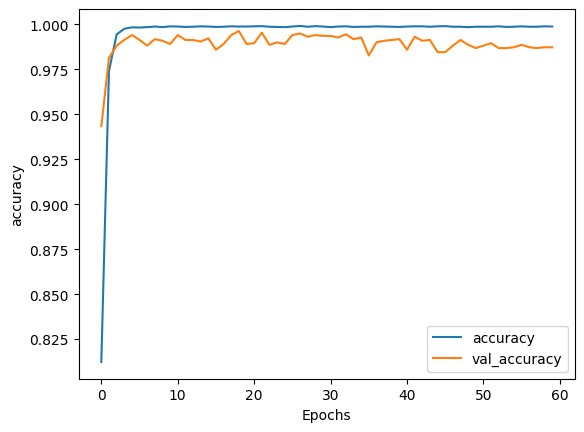

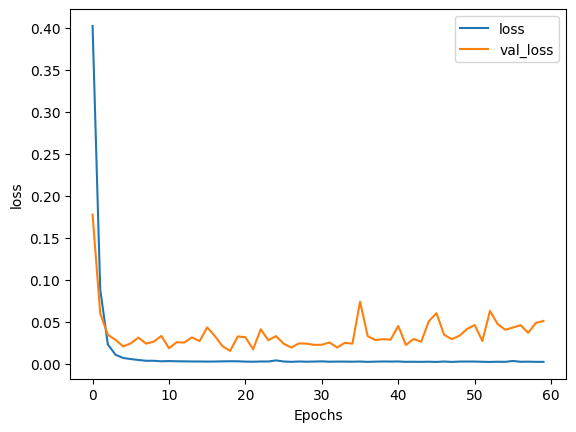

In [32]:
import matplotlib.pyplot as plt
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")   

### Save the entire model

In [33]:
# !mkdir -p ../../saved_model
model.save('../../saved_model/my_model4')


INFO:tensorflow:Assets written to: ../../saved_model/my_model4/assets


In [34]:
new_model = tf.keras.models.load_model('../../saved_model/my_model4')
# new_model.predict(train_padded_seq[1:2])

In [ ]:
train_labels[1:2]

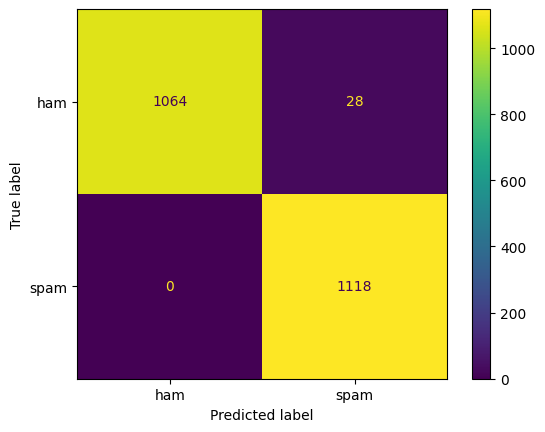

In [35]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt

predicted = new_model(val_padded_seq)
predicted = np.where(predicted>0.5, 1, 0)
confusion_matrix = confusion_matrix(val_labels, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['ham', 'spam'])

cm_display.plot()
plt.show()

In [ ]:
len(val_labels[val_labels==1])

In [ ]:
len(predicted[predicted==1])

In [36]:
sentence = 'زباله'
sentence = remove_stopwords(sentence)
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
padded_seq = seq_and_pad(tokenizer,[sentence], 'post', 250)
new_model.predict(padded_seq[0:1])

1/1 [==============================] - 0s 71ms/step


2023-05-15 13:16:43.118230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[0.91666555]], dtype=float32)